In [1]:
import os
print(os.getcwd())
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)
print(os.getcwd())

C:\Users\danie\Documents\COGS402\cogs402longformer\src
C:\Users\danie\Documents\COGS402\cogs402longformer


In [2]:
#import huggingface models
from transformers import LongformerForSequenceClassification, LongformerTokenizer

tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")
model = LongformerForSequenceClassification.from_pretrained("allenai/longformer-base-4096",num_labels=2)
model2 = LongformerForSequenceClassification.from_pretrained("src/longformer-finetuned/checkpoint-10000",num_labels=2)

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', '

In [3]:
import pandas as pd
second_ds = pd.read_csv("data/longdoc.csv")

In [4]:
from sklearn.model_selection import train_test_split
train_ds, test_ds = train_test_split(second_ds, test_size=0.2, shuffle=True, random_state=42)

In [5]:
import datasets
train_dataset = datasets.Dataset.from_pandas(train_ds)
val_dataset = datasets.Dataset.from_pandas(test_ds)

In [6]:
#trainer API auto uses dynamic padding... supposedly
def tokenize(examples):
    return tokenizer(examples["text"], truncation=True)

In [7]:
#tokenize the data
train_dataset = train_dataset.map(tokenize, load_from_cache_file=False)
val_dataset = val_dataset.map(tokenize, load_from_cache_file=False)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

In [8]:
train_dataset.set_format("torch", columns=['input_ids', 'attention_mask', "labels"])
val_dataset.set_format("torch", columns=['input_ids', 'attention_mask', "labels"])

train_dataset = train_dataset.remove_columns(['text', '__index_level_0__'])
val_dataset = val_dataset.remove_columns(['text', '__index_level_0__'])

In [9]:
print(val_dataset)

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 1179
})


In [30]:
if not os.path.exists("models"):
    os.mkdir("models")

In [31]:
from transformers import Trainer, TrainingArguments

batch_size = 1
gradient_acc = 4
logging_steps = (len(train_dataset) // batch_size) //gradient_acc
model_name = f"longformer-finetuned_v2"
training_args = TrainingArguments(output_dir=f"models/{model_name}",
                                  num_train_epochs = 2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  push_to_hub=False,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  fp16=True,
                                  gradient_accumulation_steps=gradient_acc,
                                  gradient_checkpointing=True,
                                  save_strategy = "epoch")

In [32]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [33]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

In [34]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [46]:
trainer = Trainer(
    model=model2,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator = data_collator
)

In [36]:
trainer.train()

C:\Users\danie\miniconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [16]:
preds_output = trainer.predict(val_dataset)

In [17]:
preds_output.metrics

{'test_loss': 0.36536848545074463,
 'test_accuracy': 0.9134860050890585,
 'test_f1': 0.9133801521326016,
 'test_runtime': 215.7157,
 'test_samples_per_second': 5.466,
 'test_steps_per_second': 5.466}

In [19]:
import numpy as np
y_preds = np.argmax(preds_output.predictions, axis=1)
y_true = np.array(val_dataset["labels"])

In [52]:
from sklearn.metrics import classification_report
print(
    classification_report(
        y_true, y_preds, target_names=["PL", "AI"]
    )
)

              precision    recall  f1-score   support

          PL       0.87      0.97      0.92       568
          AI       0.97      0.86      0.91       611

    accuracy                           0.91      1179
   macro avg       0.92      0.92      0.91      1179
weighted avg       0.92      0.91      0.91      1179



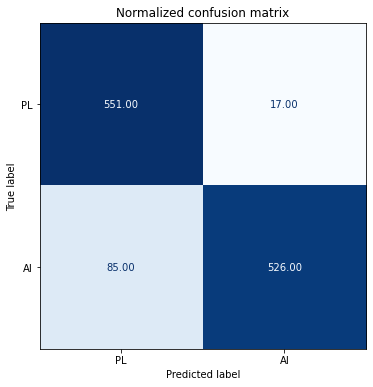

(1179,)
(1179,)


In [54]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["PL", "AI"])
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_true, labels=[0,1])
print(y_true.shape)
print(y_preds.shape)

In [37]:
# #load dataset
# dataset  = datasets.load_dataset('hyperpartisan_news_detection', 'bypublisher')

Reusing dataset hyperpartisan_news_detection (C:\Users\danie\.cache\huggingface\datasets\hyperpartisan_news_detection\bypublisher\1.0.0\7f4215b0474950ddf516e806400ab81d098b3da3b3a919a13cd1a4cf2c677012)


  0%|          | 0/2 [00:00<?, ?it/s]

In [38]:
# train_ds = dataset["train"]
# eval_ds = dataset["validation"]

In [39]:
# labels = map(int, train_ds['hyperpartisan'])
# labels = list(labels)

# labels2 = map(int, eval_ds['hyperpartisan'])
# labels2 = list(labels2)

In [40]:
# train_ds = train_ds.add_column("labels", labels)
# eval_ds = eval_ds.add_column("labels", labels2)

In [41]:
# #trainer API auto uses dynamic padding... supposedly
# def tokenize(examples):
#     return tokenizer(examples["text"], truncation=True)

In [43]:
# ## Take subset of data
# val_size = 5000
# import numpy as np

# val_indices = np.random.randint(0, len(eval_ds), val_size)
# val_ds = eval_ds.select(val_indices)

# #tokenize the data
# val_dataset2 = val_ds.map(tokenize, load_from_cache_file=False)

0ex [00:00, ?ex/s]

In [44]:

# val_dataset2.set_format("torch", columns=['input_ids', 'attention_mask', "labels"])

# val_dataset2 = val_dataset2.remove_columns(['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias'])



In [48]:
# model3 = LongformerForSequenceClassification.from_pretrained("longformer-finetuned_v2/checkpoint-2356",num_labels=2)

In [49]:
# trainer = Trainer(
#     model=model3,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
#     compute_metrics=compute_metrics,
#     tokenizer=tokenizer,
#     data_collator = data_collator
# )

In [50]:
# preds_output = trainer.predict(val_dataset2)

In [51]:
# preds_output.metrics

{'test_loss': 0.9062917232513428,
 'test_accuracy': 0.8492,
 'test_f1': 0.8455833788923798,
 'test_runtime': 489.2036,
 'test_samples_per_second': 10.221,
 'test_steps_per_second': 10.221}